In [4]:
# from fastapi import FastAPI, File, UploadFile
# from fastapi.encoders import jsonable_encoder
# from fastapi.responses import JSONResponse
# from fastapi.middleware.cors import CORSMiddleware
# from starlette.middleware.cors import CORSMiddleware
import json
# from yahoofinancials imp\`ort YahooFinancials as YF
import time
import datetime
import pandas as pd
# from pandas_datareader import data
from pandas_datareader import data as pdr

import yfinance as yf
yf.pdr_override() # <== that's all it takes :-)

from typing import List, Optional
import os
import pickle 
from tqdm import tqdm
import scipy.stats as sp
from utils import *
# from pydantic import BaseModelttt
from backtester import *
from backtest import *
import matplotlib.pyplot as plt
# import quandl
import math

# %matplotlib inline
%matplotlib notebook

In [5]:
# gets stock ticket data for current day going back days_back
def getStocksData(tickers, days_back=10, save_new=False, path=r"C:\Users\moyer\OneDrive\development\fin-dashboard\app\stocks.pkl"):
    def convert_time(epoch):
        return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(epoch))

    epoch_time = int(time.time())
    day_epoch = 60*60*24
    # tickers = df['Symbol'][:10]
    stocks = {}
    if (save_new):
        for tick in tqdm(tickers):
            try:

                # download dataframe
                # data = pdr.get_data_yahoo("SPY", start="2017-01-01", end="2017-04-30")
                # data
                # stock_data =  pdr.get_data_yahoo(tick, start="2017-01-01", end="2022-02-20")
                stock_data =  pdr.get_data_yahoo(tick, period="3mo")
                stock_data = stock_data.reset_index()
                stocks[tick] = stock_data
                with open(path, 'wb') as handle:
                    pickle.dump(stocks, handle,
                                protocol=pickle.HIGHEST_PROTOCOL)
            except:
                print("Skipping stock for {}, bad data :<".format(tick))
    else:
        with open(path, 'rb') as handle:
            stocks = pickle.load(handle)
    return stocks

In [499]:
tickers = ['AAPL','T', 'MSFT']
stocks = getStocksData(tickers, 100, save_new=True)
stocks[tickers[0]].head()

  0%|          | 0/3 [00:00<?, ?it/s]

[*********************100%***********************]  1 of 1 completed

 33%|███▎      | 1/3 [00:00<00:00,  3.44it/s]


[*********************100%***********************]  1 of 1 completed

 67%|██████▋   | 2/3 [00:00<00:00,  3.79it/s]


[*********************100%***********************]  1 of 1 completed

100%|██████████| 3/3 [00:00<00:00,  4.14it/s]

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-05-19,176.389999,176.389999,174.940002,175.160004,174.923798,55772400
1,2023-05-22,173.979996,174.710007,173.449997,174.199997,173.965073,43570900
2,2023-05-23,173.130005,173.380005,171.279999,171.559998,171.328644,50747300
3,2023-05-24,171.089996,172.419998,170.520004,171.839996,171.608261,45143500
4,2023-05-25,172.410004,173.899994,171.690002,172.990005,172.756714,56058300


In [7]:
# test offline stocks
days_back=10
save_new=False
path=r"C:\Users\moyer\OneDrive\development\fin-dashboard\app\stocks.pkl"
with open(path, 'rb') as handle:
    stocks = pickle.load(handle)
# stocks[tickers[0]]

In [8]:
df = stocks['T']

In [9]:
df
initial_capital = 100000
ticker = 'T'
bars = df
positions = pd.DataFrame(bars.index)
isBankrupt = 0
positions


# def macd(self, long=21,short=13):
#     # df = pd.DataFrame(index=self.bars[next(iter(self.bars))].index)
#     df = pd.DataFrame(index=self.bars.index)

#     # print(self.bars['Adj Close'])
#     df[self.ticker] = 0
#     df[self.ticker] = macd(

#         df=self.bars, short=short, long=long)
#     # print(df)
#     # TODO need to fix how df[self.ticker] is set since i did the reindexing
#     return df

# takes a df with colkumn "Adj Close" and returns a dataframe with
# index the same as df and 
def macd(df, short=12, long=26):
    exp1 = df['Adj Close'].ewm(span=short, adjust=False).mean()
    exp2 = df['Adj Close'].ewm(span=long, adjust=False).mean()
    df['macd'] = exp1-exp2
    # df['macd_signal'] = df['macd'].ewm(
    #     span=9, adjust=False).mean()
    df['macd_norm'] = (df['macd']-df['macd'].min()) / \
        (df['macd'].max()-df['macd'].min())
    return df['macd_norm']

macd1 = 500*macd(df, 12,23)
macd2 = macd(df, 12,43)
macd3 = macd(df, 12,53)
strat1 = pd.DataFrame(bars.index)
# strat1 = pd.DataFrame(5, index=bars.index, columns=['value'])

strat1 = pd.Series(500, index=bars.index)
strategies = [macd1,macd2,macd3]

# positions = pd.concat(strategies).groupby(level=0).sum()
# positions = pd.concat(strategies).groupby(level=0).mean()
# positions
positions['T_position'] = pd.DataFrame(5, index=bars.index, columns=['value'])

positions['T_position'] =  pd.concat(strategies).groupby(level=0).mean()

positions['T_position'].at[0] = 0
positions[ticker+'_open'] = bars.Open
positions[ticker+'_close'] = bars.Close



positions[ticker +'_pos_diff'] = positions[ticker+"_position"].diff()


# # backtest
positions[ticker+"_cash_needed"] = positions[ticker+"_pos_diff"] * bars.Open
positions[ticker+"_cash"] = initial_capital - positions[f'{ticker}_cash_needed'].cumsum()
positions[ticker+"_cash"] = initial_capital
positions[ticker+"_holdings"] = 0
positions[ticker+"_pos_diff_new"] = 0


cash_held = initial_capital
available_cash = initial_capital

for index, row in positions.iterrows():
    # print(f"index: {index}")

    if (index == 0):
        continue

    # print(row[ticker+"_pos_diff"] )

    # print(positions.loc[index])

    # shares_to_buy = pos = row[ticker+"_pos_diff"]
    price = row[ticker+"_open"]
    cash = positions.loc[index-1][ticker+"_cash"]
    holdings = positions.loc[index-1][ticker+"_holdings"]
    cash_needed = row[ticker+"_pos_diff"] * row[ticker+"_open"]

    if (cash > cash_needed):
        # make purchase
        cash = cash - cash_needed
        holdings = holdings + cash_needed
    else:
        # not enough cash so cap it
        new_pos_diff = cash / price
        positions.at[index, f"{ticker}_pos_diff_new"] = new_pos_diff
        # holdings = holdings + cash
        cash = 0
      

    # leftover = (pos*price % cash)
   
    # if ((pos * price) > cash):
    #     print('here')
    #     leftover = (pos*price % cash)
    #     shares_to_buy = cash / price
    #     if not fractional:
    #         shares_to_buy = math.floor(shares_to_buy)
    #     print(f"buying {shares_to_buy}, {price * shares_to_buy}")
    #     print(f"cash left over {cash - (price * shares_to_buy)}")

    # print(f"shares to buy {shares_to_buy}")
    # print(f"leftover cash: {leftover}")
    # row[ticker+"_holdings"] = shares_to_buy
    # row[ticker+"_cash"] = leftover
    positions.at[index, f"{ticker}_holdings"] = holdings
    positions.at[index, f"{ticker}_cash"] = cash


positions[f'{ticker}_holdings'] = positions[f"{ticker}_position"] * positions[f"{ticker}_open"]

positions['total'] = positions[f"{ticker}_cash"] + positions[f"{ticker}_holdings"]

positions= positions.round(2)
    # if (row[ticker+"_cash_needed"] < 0):
    #     isBankrupt = index
    #     available_cash = initial_capital - positions[f'{ticker}_cash_needed'][:index-1].sum()
    #     print(f"{ticker} went bankrupt at {index} with {available_cash} of available cash and {initial_capital}")



# def setCash(pos, price, cash):
#     print(pos)
#     print(price)
#     if (pos*price > cash):
#         print('not enouch cash')
#         leftover = (pos*price % cash)
#         shares_to_buy = cash / price
#         if not fractional:
#             shares_to_buy = math.floor(shares_to_buy)
#         print(f"buying {shares_to_buy}, {price * shares_to_buy}")
#         print(f"cash left over {cash - (price * shares_to_buy)}")

# positions = positions.assign(
#     T_cash = lambda x: setCash(x['T_position'],x['T_open'], x['T_cash'])
# )




# df_filled = df.fillna(0)
positions.total.plot()
# positions.total.plot()

 
# macd1


<IPython.core.display.Javascript object>

<Axes: >

In [10]:
positions.head(50)

,0,T_position,T_open,T_close,T_pos_diff,T_cash_needed,T_cash,T_holdings,T_pos_diff_new,total
0,0,0.00,16.59,16.31,NaN,NaN,100000.00,0.00,0,100000.00
1,1,163.97,16.35,16.38,163.97,2680.90,97319.10,2680.90,0,100000.00
2,2,156.41,16.26,16.10,-7.56,-122.95,97442.05,2543.20,0,99985.24
3,3,145.60,16.11,15.95,-10.80,-174.06,97616.11,2345.68,0,99961.78
4,4,110.73,15.67,15.15,-34.87,-546.45,98162.56,1735.16,0,99897.72
5,5,96.01,15.23,15.50,-14.72,-224.22,98386.78,1462.22,0,99848.99
6,6,90.10,15.49,15.64,-5.91,-91.54,98478.31,1395.64,0,99873.96
7,7,89.43,15.66,15.73,-0.67,-10.43,98488.75,1400.53,0,99889.27
8,8,92.51,15.75,15.81,3.08,48.45,98440.29,1457.03,0,99897.32
9,9,75.76,15.08,15.21,-16.75,-252.61,98692.90,1142.44,0,99835.34


In [3]:
# old one
class Stock(object):
    def __init__(self, bars, ticker, initial_capital=1000):
        self.bars = bars # df of the Open, High, Low, Close, Adj Close, Volume, with Date as index
        self.ticker = ticker # str: ticket symbol
        self.positions = pd.DataFrame(
            index=self.bars[next(iter(self.bars))].index) # empty df with same index as bars
        self.strategies = [] # list of df's with single column as the "buy signal" with the column name being the ticker
        self.initial_capital = float(initial_capital)

    def generate_positions(self):
#         print("generate positoins called", self.ticker)
#         print(self.strategies)
#         print(type(self.strategies))
        if not self.strategies:
            # just set to zero
            self.positions = pd.DataFrame(
                index=self.bars[next(iter(self.bars))].index)
            self.positions[self.ticker] = 0.0
            self.positions[self.ticker+"_position"] = 0
            self.positions[self.ticker +
                           '_pos_diff'] = self.positions[self.ticker+"_position"].diff()
            return self.positions

        self.positions = pd.concat(self.strategies).groupby(['Date']).sum()

        self.positions[self.ticker+"_position"] = 1*self.positions[self.ticker]
        self.positions[self.ticker +
                       '_pos_diff'] = self.positions[self.ticker+"_position"].diff()
        return self.positions

    # takes your
    def backtest(self):
        if self.ticker+"_position" not in self.positions.columns:
            self.generate_positions()
        holdings_col = []
        holdings_col.append(self.ticker+"_holdings")
        self.positions[self.ticker+'_cash'] = (
            self.positions[self.ticker+'_pos_diff'] * self.bars.Open)
        self.positions[self.ticker+"_holdings"] = self.bars.Open * \
            self.positions[self.ticker+'_position']
        self.positions[self.ticker+'_open'] = self.bars.Open
        self.positions[self.ticker+'_close'] = self.bars.Close
        self.positions['holdings'] = self.positions[holdings_col].sum(axis=1)
        self.positions['cash_diff'] = self.positions[[
            x.replace('_holdings', '_cash') for x in holdings_col]].sum(axis=1)
        self.positions['cash'] = self.initial_capital - \
            self.positions['cash_diff'].cumsum()
        self.positions['total'] = self.positions['cash'] + \
            self.positions['holdings']
        self.positions['returns'] = self.positions['total'].pct_change()
        self.positions['date'] = self.positions.index.strftime("%m/%d/%Y")
        self.positions = self.positions.fillna(0)
        return self.positions
    # takes a dict of weights and returns positions

    def buyWeights(self,weight):
        # assert(weights.keys() in self.bars.keys())
        df = pd.DataFrame(index=self.bars[next(iter(self.bars))].index)
        df[self.ticker] = weight
        df[self.ticker][0:1] = 0.0
        return df

    def macd(self, long=21,short=13):
        df = pd.DataFrame(index=self.bars[next(iter(self.bars))].index)

        df[self.ticker] = 0
        df[self.ticker] = macd(
            df=self.bars, short=short, long=long)
        return df
    
stock = Stock()


In [2]:
# TODO 
# Add limit so capital can't go under 0



class Stock(object):
    def __init__(self, bars, ticker, initial_capital=1000):
        self.bars = bars # df of the Open, High, Low, Close, Adj Close, Volume, with Date as index
        self.ticker = ticker # str: ticket symbol
        self.positions = pd.DataFrame(
            index=self.bars.index) # empty df with same index as bars
        self.strategies = [] # list of df's with single column as the "buy signal" with the column name being the ticker
        self.initial_capital = float(initial_capital)
        self.isBankrupt = 0 # 0 if not bankrupt, date of bankruptcy

    def generate_positions(self):
#         print("generate positoins called", self.ticker)
#         print(self.strategies)
#         print(type(self.strategies))
        if not self.strategies:
            # create a series with same index and fixed value
            self.positions[self.ticker+"_position"] = pd.DataFrame(5, index=bars.index, columns=['value'])
            self.positions[self.ticker +'_pos_diff'] = self.positions[self.ticker+"_position"].diff()
            return self.positions

        print('strategies')
        print(self.strategies)
        print('positions')
        print(self.positions)
        self.positions = pd.concat(self.strategies).groupby(level=0).sum()

        self.positions[self.ticker+"_position"] = 1*self.positions[self.ticker]
        self.positions[self.ticker +
                       '_pos_diff'] = self.positions[self.ticker+"_position"].diff()
        
        self.positions.loc[self.positions.index[0],self.ticker +'_pos_diff'] = self.positions.loc[self.positions.index[0],self.ticker +'_position']
        return self.positions

    # takes your
    def backtest(self):
        if self.ticker+"_position" not in self.positions.columns:
            print(f"Generating positions first")
            self.generate_positions()
        holdings_col = []
        holdings_col.append(self.ticker+"_holdings")
        self.positions[self.ticker+'_cash_needed'] = (
            self.positions[self.ticker+'_pos_diff'] * self.bars.Open)
        # self.positions[self.ticker+"_holdings"] = self.bars.Open * \
        #     self.positions[self.ticker+'_position']

        self.positions[self.ticker+'_open'] = self.bars.Open
        self.positions[self.ticker+'_close'] = self.bars.Close



        # self.positions['holdings'] = self.positions[holdings_col].sum(axis=1)

        # self.positions['cash_diff'] = self.positions[[
        #     x.replace('_holdings', '_cash') for x in holdings_col]].sum(axis=1)
        
        # print('test')
        # print([x.replace('_holdings', '_cash') for x in holdings_col])
        

        self.positions['cash'] = self.initial_capital - \
            self.positions[f'{self.ticker}_cash_needed'].cumsum()
        

        cash_held = self.initial_capital
        for index, row in self.positions.iterrows():
            if (row['cash'] < 0):
                self.isBankrupt = index
                available_cash = self.initial_capital - self.positions[f'{self.ticker}_cash_needed'][:index-1].sum()
                print(f"{self.ticker} went bankrupt at {index} with {available_cash} of available cash and {self.initial_capital}")



        

            # holdings = row[f'{self.ticker}_position'] * row[self.ticker+'_open']
            # cash_held = cash_held - holdings

            # if (cash_held < 0):
            #     print(f"{self.ticker} went bankrupt at {index}")
            #     self.isBankrupt = index
            #     break
            # else:
            #     self.positions.at[index, 'holdings'] = holdings

            #     self.positions.at[index, 'cash_diff'] = self.positions[[
            #         x.replace('_holdings', '_cash') for x in holdings_col]].sum(axis=1)
            #     # self.positions.at[index,'cash'] = cash_held - \
            #     #     self.positions['cash_diff'].cumsum()
        


            

        # # self.positions['new_col'] = df.apply(lambda x: some_func(x['col1'], x['col2'])) 
        # self.positions = self.positions.assign(
        #     holdings = lambda x: self.setHoldings(x[f"{self.ticker}_position"],x[f"{self.ticker}_open"]),
        #     cash_diff = lambda x: self.setCash_Diff(x,holdings_col,x['holdings'], x[f'{self.ticker}_close']),
        #     cash = lambda x: x['holdings'] * x[f'{self.ticker}_close']
        # )
      
        
        # self.positions['total'] = self.positions['cash'] + \
        #     self.positions['holdings']
        

        # self.positions['returns'] = self.positions['total'].pct_change()
        # self.positions['date'] = self.positions.index.strftime("%m/%d/%Y")
        # self.positions = self.positions.fillna(0)
        return self.positions
    
    def setHoldings(self,position,open_price):
        print("set holdings")
        holdings = position * open_price
        if (self.initial_capital - holdings < 0):
            print(f"{self.ticker} stock position has gone broke")
        print(position)
        print(open_price)
        print(self.initial_capital)
        return position
    
    def setCash_Diff(self,df,holdings_col,holdings, close_price):
        cash_diff = df[[
            x.replace('_holdings', '_cash') for x in holdings_col]].sum(axis=1)
        return cash_diff


    # takes a dict of weights and returns positions

    def buyWeights(self,weight):
        # assert(weights.keys() in self.bars.keys())
        # df = pd.DataFrame(index=self.bars[next(iter(self.bars))].index)
        df = pd.DataFrame(index=self.bars['Date'])
        df[self.ticker] = weight
        df[self.ticker][0:1] = 0.0
        return df

    def macd(self, long=21,short=13):
        # df = pd.DataFrame(index=self.bars[next(iter(self.bars))].index)
        df = pd.DataFrame(index=self.bars.index)
    
        # print(self.bars['Adj Close'])
        df[self.ticker] = 0
        df[self.ticker] = macd(
            df=self.bars, short=short, long=long)
        # print(df)
        # TODO need to fix how df[self.ticker] is set since i did the reindexing
        return df


In [467]:
stock = Stock(stocks['AAPL'], 'AAPL',100)
stock.ticker

strats = [
    stock.macd(long = 21, short = 1),
    stock.buyWeights(32)
]
stock.strategies = strats
stock.backtest()

stock.positions
# stock.positions['total'].plot()


# stock.positions
# stock.strategies[0].columns
# positions = pd.concat(stock.strategies).groupby(['Date']).sum()
# positions


# def merge_strategies(type="even", strats):
#     if (type=='even'):
        
    

KeyError: 'Date'

In [ ]:
class Portfolio(object):
    """An abstract base class representing a portfolio of 
    positions (including both instruments and cash), determined
    on the basis of a set of signals provided by a Strategy."""

    __metaclass__ = ABCMeta

    def __init__(self, tickers, bars, initial_capital=1000):
        self.tickers = tickers
        self.bars = bars # dict of the ticker:OHLC df
        self.stock_list = []
        self.stocks = {}  # dict of Class Stock[]
        # self.stocks = [Stock(self.stocks[x],x, self.initial_capital/len(self.tickers)) for x in self.tickers]
        self.backtest = {}
        self.positions = {} # might not be needed if the self.stocks will have the positions, we can store the aggregated positions here
        self.strategies = []
        self.initial_capital = initial_capital
        self.prepStockData()
        
    # takes a strat or list of stras and adds it to the stocks stratigies to execute
    # all takes a list of tickers to put the strategy in
    def addStrat(self, tickers, strat, **kwargs):
#         print('adding strat ', tickers, strat)
        for tick in tickers:
            print(f"adding ticker {tick}")
            if isinstance(strat, str):
                print("adding single strat")
                try:
                    func = getattr(self.stocks[tick], strat)(**kwargs)
#                     print(func)
                    self.stocks[tick].strategies.append(func)
                except AttributeError:
                    print("dostuff not found")
                
            else:
                print("adding multiple strats")
                print(self.stocks)
                print("strats")
                print(strat)
                
#                 self.stocks[tick].strategies.extend(strat)
                for signal in strat:
                    # print(signal)
                    self.stocks[tick].strategies.append(signal[tick])

#                     print('signal')
#                     print(signal)
#                     print('signal value:')

#                     print(signal['value'])
                    # self.stocks[signal['key']].strategies.append(signal['value']) 
               
                print(f"added strats {strats} to stocks {stocks}")

    # creates the Stock objects and adds them to the self.stocks dict
    def prepStockData(self):
        for ticker in self.tickers:
            self.stocks[ticker] = Stock(self.bars[ticker],ticker,1000) 


    def backtest_portfolio(self):
        for stock in self.tickers:
            self.stocks[stock].backtest()
        sample_df = self.stocks[self.tickers[0]].bars
#         print(sample_df)
        self.positions = pd.DataFrame(index=self.bars[next(iter(self.bars))].index) # empty df with same index as bars
        all_positions = [self.stocks[x].positions for x in self.tickers]
        self.positions = pd.DataFrame(index=sample_df[next(iter(sample_df))].index) # empty df with same index as bars

        sum_cols = ['holdings', 'cash', 'total']
        for col in sum_cols:
            self.positions[col] = pd.concat(all_positions).groupby('Date')[col].sum()

        return self.positions

    # returns a dict of the symbol:[a df of the strategy with a Date index]
    def markowitz(self, params, weight=1):
        df = pd.DataFrame(index=self.bars[next(iter(self.bars))].index)
        bars = addReturns(self.bars, 'Adj Close')
        port_returns = getPortReturns(bars)
        risk_free = 0
        markov_runs = 100
        tickers = self.bars.keys()
        df = pd.DataFrame(columns=["id", "return", "volatility", "weights"])
        for x in range(0, int(markov_runs)):
            weights = getRandomWeights(len(tickers))
            volatility = getPortWeightedVol(port_returns, weights)
            ann_ret = getPortWeightedAnnualReturn(port_returns, weights)
            row = {
                "id": x,
                "return": ann_ret,
                "volatility": volatility,
                "weights": weights
            }
            # df = df.append(row, ignore_index=True)
            # df = df.concat([df,row])
            df = pd.concat([df, pd.DataFrame.from_records([row])])
        df["sharpe"] = (df["return"] - risk_free) / df["volatility"]

        MSR = df.sort_values(by=["sharpe"], ascending=False).head(1)
        GMV = df.sort_values(by=["volatility"], ascending=True).head(1)
        weights = {}
        for index, x in enumerate(list(MSR['weights'])[0]):
            weights[list(tickers)[index]] = x * weight

        df = pd.DataFrame(index=self.bars[next(iter(self.bars))].index)
        for ticker in params['tickers']:
            df[ticker] = weights[ticker]
        print("Optimum", weights)
        # buy weights
        result = {}
        for stock in self.tickers:
#             print(stock)
#             print(self.stocks[stock].buyWeights(weights[stock]))
            # strategy = {
            #     'key': stock,
            #     'value':self.stocks[stock].buyWeights(weights[stock])
            # }
            result[stock] = self.stocks[stock].buyWeights(weights[stock])
#             result[stock] = self.stocks[stock].buyWeights(weights[stock])
#             self.stocks[stock].strategies.append(self.stocks[stock].buyWeights(weights[stock])) #= [self.stocks[stock].buyWeights(weights[stock])]
        return result
     
    # returns a dict of the symbol:[a df of the strategy with a Date index]
    def buyEven(self, weight=1):
        result = []
        for stock in self.stocks.keys():
#             result[stock] = self.stocks[stock].buyWeights(weight)
            strategy = {
                'key': stock,
                'value':self.stocks[stock].buyWeights(weight)
            }
            result.append(strategy)
#             self.stocks[stock].strategies.append(self.stocks[stock].buy 

Optimum {'AAPL': 0.520155714104913, 'T': 0.003489042485182706, 'MSFT': 0.47635524340990426}
adding ticker AAPL
adding multiple strats
{'AAPL': <__main__.Stock object at 0x158214a90>, 'T': <__main__.Stock object at 0x158314f50>, 'MSFT': <__main__.Stock object at 0x1582b9910>}
strats
({'AAPL':                 AAPL
Date                
2023-04-21  0.000000
2023-04-24  0.520156
2023-04-25  0.520156
2023-04-26  0.520156
2023-04-27  0.520156
...              ...
2023-07-14  0.520156
2023-07-17  0.520156
2023-07-18  0.520156
2023-07-19  0.520156
2023-07-20  0.520156

[62 rows x 1 columns], 'T':                    T
Date                
2023-04-21  0.000000
2023-04-24  0.003489
2023-04-25  0.003489
2023-04-26  0.003489
2023-04-27  0.003489
...              ...
2023-07-14  0.003489
2023-07-17  0.003489
2023-07-18  0.003489
2023-07-19  0.003489
2023-07-20  0.003489

[62 rows x 1 columns], 'MSFT':                 MSFT
Date                
2023-04-21  0.000000
2023-04-24  0.476355
2023-04-25  0.47

<Axes: xlabel='Date'>

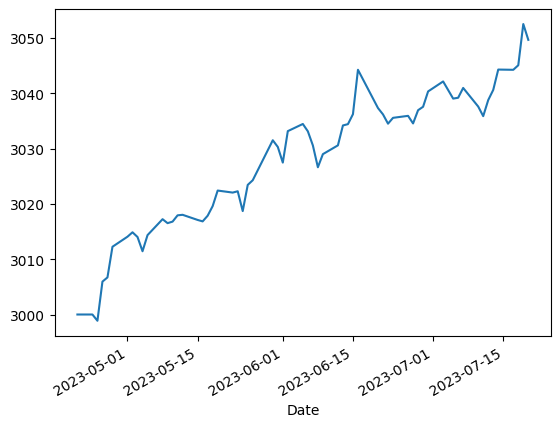

In [ ]:
tickets =  ['AAPL', 'T','MSFT']
port = Portfolio(tickets, stocks,10000);
markowtiz_params = {
    'tickers': ['AAPL', 'T','MSFT'],
    'weight':1
}
strats = port.markowitz(params = markowtiz_params,weight=1),
    # port.buyEven(3),

port.addStrat(tickets,strats)
port.backtest_portfolio()

port.positions['total'].plot()

# port.stocks['T'].positions

# port.stocks['AAPL'].positions.total.plot()

# port.markowitz(params = markowtiz_params,weight=1)['T'].positions
# stocks

# tickers

In [ ]:
port.markowitz(params = markowtiz_params,weight=1)

Optimum {'AAPL': 0.7421837881156286, 'T': 0.0269034697609557, 'MSFT': 0.23091274212341567}


{'AAPL':                 AAPL
 Date                
 2023-04-21  0.000000
 2023-04-24  0.742184
 2023-04-25  0.742184
 2023-04-26  0.742184
 2023-04-27  0.742184
 ...              ...
 2023-07-14  0.742184
 2023-07-17  0.742184
 2023-07-18  0.742184
 2023-07-19  0.742184
 2023-07-20  0.742184
 
 [62 rows x 1 columns],
 'T':                    T
 Date                
 2023-04-21  0.000000
 2023-04-24  0.026903
 2023-04-25  0.026903
 2023-04-26  0.026903
 2023-04-27  0.026903
 ...              ...
 2023-07-14  0.026903
 2023-07-17  0.026903
 2023-07-18  0.026903
 2023-07-19  0.026903
 2023-07-20  0.026903
 
 [62 rows x 1 columns],
 'MSFT':                 MSFT
 Date                
 2023-04-21  0.000000
 2023-04-24  0.230913
 2023-04-25  0.230913
 2023-04-26  0.230913
 2023-04-27  0.230913
 ...              ...
 2023-07-14  0.230913
 2023-07-17  0.230913
 2023-07-18  0.230913
 2023-07-19  0.230913
 2023-07-20  0.230913
 
 [62 rows x 1 columns]}

In [493]:
import pickle
import time
import backtrader as bt
import pandas as pd


# Custom backtrader Data Feed class
class MyStocksData(bt.feeds.PandasData):
    lines = ('datetime', 'open', 'high', 'low', 'close', 'volume', 'openinterest')
    params = (('openinterest', None),)  # No open interest column

    def get_data(self):
        data = getStocksData(self.p.tickers, self.p.days_back, self.p.save_new, self.p.path)

        # Concatenate data from all tickers
        df = pd.concat(data.values(), keys=data.keys(), names=['ticker', 'date'])

        # Drop the 'ticker' level and reset index
        df.reset_index(level='ticker', drop=True, inplace=True)

        # Convert the index to datetime
        df.index = pd.to_datetime(df.index)

        return df

# Main code
if __name__ == '__main__':
    # Parameters for your data fetch function
    tickers = ['AAPL', 'GOOGL', 'MSFT']  # List of tickers to fetch data for
    days_back = 10  # Number of days of historical data to fetch
    save_new = True  # Set to True to save new data to a file, set to False to load existing data
    path = r"C:\Users\moyer\OneDrive\development\fin-dashboard\app\stocks.pkl"  # Path to the data file

    # Create a Cerebro instance
    cerebro = bt.Cerebro()

    # Add your custom Data Feed to Cerebro
    data = MyStocksData(dataname='dummy',  # dataname is a dummy value, as get_data method fetches the data directly
                        tickers=tickers,
                        days_back=days_back,
                        save_new=save_new,
                        path=path)

    cerebro.adddata(data)

    # Run your backtest or apply strategies on the data
    cerebro.run()


TypeError: PandasData.__init__() got an unexpected keyword argument 'tickers'

In [ ]:
df.to_csv('out.csv')

In [496]:
stocks['T'].to_csv('./datasets/stock_csvs/T.csv',index=False)